# Antenna Beams

Antennas are devices for coupling electromagnetic fields onto wires (usually as a voltage or current signal). The simplest antenna is a **dipole**, which allows electrical current to flow from one end to another. In the middle, this current is usually made to run through a coil of wire (a **balun**) to induce a voltage/current signal on a separate circuit that is used for analysis.

Around our antenna (which we often call a **feed**), we usually build a dish that collects signal over a larger area and focuses it onto our feed.  This dish increases our forward **gain** (the amplitude of the incoming signal), but it does so at a cost of sensitivity in other directions. As a general rule, the angular size of an antennas response pattern (its **beam** width), scales inversely with diameter:
\begin{equation}
\theta\approx 1.22 \frac{\lambda}{d},
\end{equation}
where $\theta$ is the angular width of the beam in radians, $\lambda$ is the wavelength of the radiation, 
and $d$ is the diameter of the dish.

Our dishes are two-dimensional. The **solid angle** of the 
beam, $\Omega$, is measured in steradians (two-dimensional radians), and for small angles, $\Omega\approx\theta^2$.
This approximation breaks down for large beams, because the sky is curved and there are a maximum of $4\pi$ steradians.

The angular area of a beam, $\Omega$, picks up incoming **intensity** (or brightness), $I$, over a patch of sky 
and collects up the resultant **flux** $F=I\Omega$ over the surface area of the dish (the aperture) to get a
signal power that is injected onto a wire as a varying voltage.

More generally, we express the **beam pattern** of an antenna as a function of direction $\hat s$ as $A(\hat s)$.  Using this notation, the soid angle of the beam is given by
\begin{equation}
\Omega = \oint A(\hat s) d\Omega
\end{equation}

## Simulation

In this simulation, we visualize the incoming radiation as a noise-like signal (which, for our purposes, it almost always is) generated by an astrophysical source. The square of the visualized electromagnetic wave is proportional
to the intensity, $I$.

This intensity is picked up by the beam response, which we plot in blue. The curve's radial distance versus angle indicates its power response toward that direction on a logrithmic scale.

Try moving the source around on the sky and adjusting the dish size to see how the voltage signal output by the antenna changes.

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from ipywidgets import interact, FloatSlider, Layout

In [34]:
# High-level parameters
SIZE = 256     # number of points in each line
RMAX = 10      # radius of simulation (i.e. length of each line)
NSTEPS = 300   # number of cycles in simulation before repeat

# Variables derived from parameters above
xs = np.linspace(0, RMAX, SIZE)
radiation = (xs, np.random.normal(size=SIZE)) # x,y coordinates of E field
angles = np.linspace(0, np.pi, SIZE)
beam = np.exp(-(angles-np.pi/2)**2/2)
signal = np.zeros_like(xs)
dish_x = np.linspace(-RMAX/30, RMAX/30, SIZE)
dish_y = dish_x**2

def update_data(diameter, angle):
    """Launch photon wavelets along each line, propagating radially outward 
    at one index per simulation cycle."""
    global beam, dish_x, dish_y
    radiation[1][:-1] = radiation[1][1:] #  propagate radiation inward
    radiation[1][-1] = np.random.normal() # put new noise at end
    gain = 10 * diameter**2
    bm_pattern = np.cos((angles-np.pi/2) * diameter)**2 * np.exp(-(angles-np.pi/2)**2 * diameter**2/2)
    beam = gain * bm_pattern
    dish_x = np.linspace(-RMAX/30*diameter, RMAX/30*diameter, SIZE)
    dish_y = 0.7 * diameter/RMAX * (dish_x / dish_x.max())**2
    signal[1:] = signal[:-1] # shift right
    signal[0] = radiation[1][0] * beam[np.argmin(np.abs(angles - angle))]

<IPython.core.display.Javascript object>


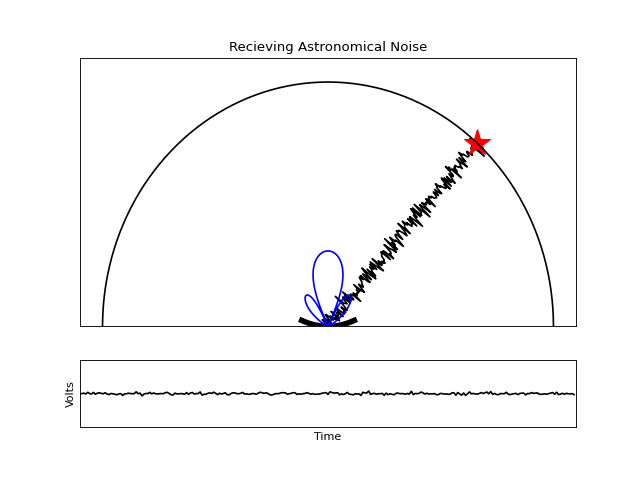

interactive(children=(FloatSlider(value=1.5707963267948966, description='Hour Angle [radians]', layout=Layout(…

In [38]:
# Generate the animation figure

fig = plt.figure(figsize=(8,6))
gs = GridSpec(ncols=1, nrows=2, height_ratios=[4, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

rad_plt, = ax1.plot(radiation[0], radiation[1], 'k') # holds handle for incoming radiation
src_plt, = ax1.plot([0], [RMAX], 'r*', markersize=25) # holds handle for plotting radiating source
circle, = ax1.plot(RMAX * np.cos(angles), RMAX * np.sin(angles), 'k')
dish_plt, = ax1.plot(dish_x, dish_y, 'k', linewidth=5)
bm_plt, = ax1.plot(np.cos(angles) * beam, np.sin(angles) * beam, 'b')
sig_plt, = ax2.plot(signal, 'k')

# Sliders controlling simulation
angle_widget = FloatSlider(np.pi/2, min=0, max=np.pi, step=0.01,
                           description='Hour Angle [radians]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))
diameter_widget = FloatSlider(1, min=0.5, max=5.0, step=0.25,
                           description='Antenna Diameter [m]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))

def animate(t):
    '''Update plots for each line according to the time step. Reads theta
    from theta_widget. Called repeatedly by FuncAnimation.'''
    angle = np.pi - angle_widget.value
    diameter = diameter_widget.value
    amp = 0.2
    update_data(diameter, angle)
    # Update received noise signal 
    sig_plt.set_ydata(signal)
    # Rotate radiation x,y to point to source location
    rad_plt.set_xdata(np.cos(angle) * radiation[0] - amp * np.sin(angle) * radiation[1])
    rad_plt.set_ydata(np.sin(angle) * radiation[0] + amp * np.cos(angle) * radiation[1])
    # Update source
    src_plt.set_xdata([RMAX * np.cos(angle)])
    src_plt.set_ydata([RMAX * np.sin(angle)])
    # Translate beam response into a linlog radial diagram
    bm_plt.set_xdata(np.cos(angles) * (1 + np.log10(0.1 + beam)))
    bm_plt.set_ydata(np.sin(angles) * (1 + np.log10(0.1 + beam)))
    # Update dish size
    dish_plt.set_xdata(dish_x)
    dish_plt.set_ydata(dish_y)
    
    
def init():
    '''Set initial plot parameters. Called once by FuncAnimation at beginning.'''
    ax1.set_title('Recieving Astronomical Noise')
    ax1.set_xlim(-1.1 * RMAX, 1.1 * RMAX)
    ax1.set_ylim(0, 1.1 * RMAX)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.set_ylim(-150, 150)
    ax2.set_xlim(0, SIZE)
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volts')
    
steps = np.linspace(0, 1, NSTEPS) # simulation interval
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=True)

def build_animation(angle, diameter):
    '''Function which causes FuncAnimation to redraw itself, when freq_widget changes.
    Does not actually hand off the value, but needs to accept an argument tied to
    freq_widget in order to be triggered by updating the slider.'''
    ani.new_frame_seq()

# force animation to redraw when freq_widget changes, even though
# the parameter is not actually passed through (used as global, instead)
interact(build_animation, angle=angle_widget, diameter=diameter_widget)
plt.show()

Notice how, if the source is directly overhead, increasing the dish size increases the amplitude of the voltage signal, but off-axis, the beam response falls off with dish diameter.